In [12]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import xgboost as xgb
from hyperopt import fmin, tpe, space_eval, hp, STATUS_OK, Trials
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import Sequential
from keras.regularizers import l1, l2
from numpy.random import default_rng
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import scipy
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.metrics import recall_score, precision_score

%matplotlib inline

In [3]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df_provinces = df[['Dónde estás trabajando', 'Salario mensual BRUTO (en tu moneda local)']].groupby('Dónde estás trabajando').agg(['median', 'count']).sort_values(('Salario mensual BRUTO (en tu moneda local)', 'median'))
provinces_geo = gpd.read_file('provincias_argentinas_polygon.geojson')
provinces_geo['provincia'] = provinces_geo['provincia'].apply(lambda x: "Tierra del Fuego" if x == "Tierra del Fuego e Islas del Atlántico Sur" else x)
provinces = provinces_geo.join(df_provinces['Salario mensual BRUTO (en tu moneda local)'], on=['provincia'])
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
provinces_geo['region'] = provinces_geo['provincia'].apply(lambda x: regions_map[x])
df['region'] = df['Dónde estás trabajando'].apply(lambda x: regions_map[x])
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}


df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]
df

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?",region
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,NaN,NaN,201-500,Otras industrias,6,6,4.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN,NOA
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,No,NaN,11-50,Servicios / Consultoría de Software / Digital,5,8,2.0,Abono de celular y/o Internet,NaN,NOA
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,NaN,Ekoparty,11-50,Servicios / Consultoría de Software / Digital,10,10,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN,NEA
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,No,NaN,11-50,Producto basado en Software,5,3,-1.0,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN,NEA
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,NaN,"Pynea, Autodefensa digital",201-500,Otras industrias,8,9,5.0,"Abono de celular y/o Internet, Comidas pagas /...",NaN,NEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,Hombre,40,Tucumán,9.0,2.0,1.0,2,Universitario,Completado,Licenciatura en Informática,...,No,NaN,1-10,Producto basado en Software,10,5,-1.0,Ninguna de las anteriores,Ninguna,NOA
5977,Hombre,33,Tucumán,4.0,0.0,0.0,0,Terciario,Incompleto,Analista de Sistemas,...,No,NaN,201-500,Servicios / Consultoría de Software / Digital,9,10,1.0,"Capacitaciones y/o cursos, Clases de idiomas","Ninguna, todas son una mierda.",NOA
5978,Hombre,26,Tucumán,4.0,4.0,4.0,1,Terciario,En curso,Tecnicatura en Programación,...,No,Bootcamp,51-100,Servicios / Consultoría de Software / Digital,10,10,10.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",Everis globant sovos,NOA
5979,Hombre,32,Tucumán,11.0,11.0,11.0,0,Terciario,Completado,Prof. Educación Tecnologica,...,No,NaN,101-200,Otras industrias,7,3,3.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN,NOA


In [4]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297, 'random_state': 0}
class Model:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en el último año?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))


cross_val_score(estimator=Model(**best), X=df, y=df['Salario mensual BRUTO (en tu moneda local)'], cv=5).mean()

0.5175749136776264

In [6]:
model = Model(**best).fit(df, df['Salario mensual BRUTO (en tu moneda local)'])
model.regressor_.base_score = 0.0

df_gender = df[(df['Me identifico'] == 'Hombre') | (df['Me identifico'] == 'Mujer')]
df_gender.loc[:, 'Me identifico'] = 'Hombre'
men_pred = model.predict(df_gender)
df_gender.loc[:, 'Me identifico'] = 'Mujer'
women_pred = model.predict(df_gender)
((men_pred - women_pred) / men_pred).mean()

0.048644472

In [7]:
df = df[df['Me identifico'] != 'Otros']

In [8]:
ch = '#FF7F0E'
cm = '#1F77B4'

In [9]:
(
df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(),
df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(),
)

(77000.0, 62050.0)

In [10]:
df['Me identifico'].value_counts()

Hombre    4922
Mujer      820
Name: Me identifico, dtype: int64

In [13]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297}
class Model:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en el último año?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
    
kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_models = []
for train_index, test_index in kf.split(df):
    model = Model(random_state=99).fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'])
    df.loc[df.index[test_index], 'e(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    df.loc[df.index[test_index], 'e_gr(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    kf_models.append(model)
df['e_h(salary)'] = df.apply(lambda row: row['e(salary)'] if row['Me identifico'] == 'Hombre' else row['e_gr(salary)'], axis=1)
df['e_m(salary)'] = df.apply(lambda row: row['e(salary)'] if row['Me identifico'] == 'Mujer' else row['e_gr(salary)'], axis=1)
df['e_g_diff(salary)'] = (df['e_h(salary)'] - df['e_m(salary)']) / df['e_h(salary)']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [14]:
(df['e_h(salary)'].median(), df['e_m(salary)'].median())

(80492.9296875, 74243.13671875)

In [15]:
df[df['Me identifico'] == 'Hombre']['e_h(salary)'].median(),df[df['Me identifico'] == 'Mujer']['e_h(salary)'].median()

(81518.89453125, 74263.00390625)

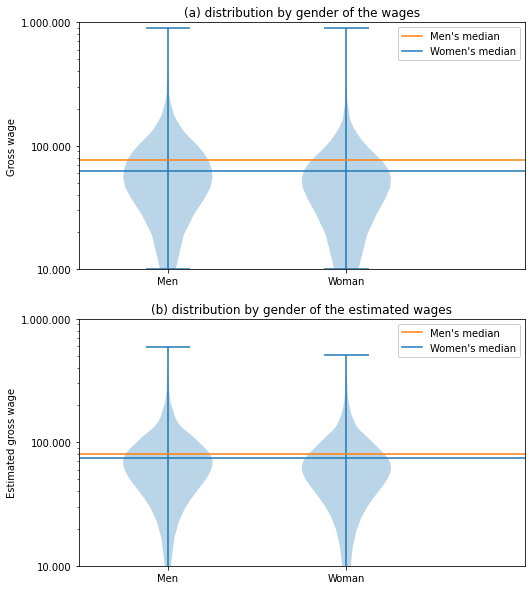

In [16]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 10));
ax0.axhline(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(), c=ch)
ax0.axhline(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(), c=cm)
ax0.set_ylabel('Gross wage')
ax0.set_yscale('log')
ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Men', 'Woman'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax0.violinplot([
    df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].values,
    df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].values,
]);
legend = ax0.legend(["Men's median", "Women's median"])
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 1, 0.))
ax0.set_title('(a) distribution by gender of the wages')
ax0.patch.set_alpha(0.0)

ax1.axhline(df['e_h(salary)'].median(), c=ch)
ax1.axhline(df['e_m(salary)'].median(), c=cm)
ax1.set_ylabel('Estimated gross wage')
ax1.set_yscale('log')
ax1.set_xlim(0.5, 3)
ax1.set_ylim(10_000, 1_000_000)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Men', 'Woman'])
ax1.set_yticks([10_000, 100_000, 1_000_000])
ax1.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax1.violinplot([
    df['e_h(salary)'].values,
    df['e_m(salary)'].values,
]);
legend = ax1.legend(["Men's median", "Women's median"])
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 1, 0.))
ax1.set_title('(b) distribution by gender of the estimated wages');
ax1.patch.set_alpha(0.0);


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


''

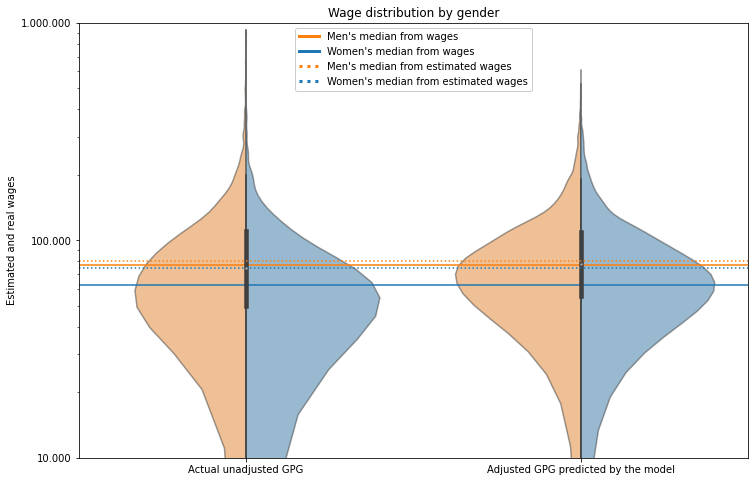

In [17]:

b = df[['Me identifico', 'Salario mensual BRUTO (en tu moneda local)']]
b.loc[:, 'source'] = 'Actual unadjusted GPG'
a = df[['e_h(salary)']].rename(columns={'e_h(salary)': 'Salario mensual BRUTO (en tu moneda local)'})
a['Me identifico'] = 'Hombre'
a['source'] = 'Adjusted GPG predicted by the model'
c = df[['e_m(salary)']].rename(columns={'e_m(salary)': 'Salario mensual BRUTO (en tu moneda local)'})
c['Me identifico'] = 'Mujer'
c['source'] = 'Adjusted GPG predicted by the model'
violindata = pd.concat((b, a, c), axis=0)

_, ax0 = plt.subplots(1, 1, figsize=(12, 8));
ax0.axhline(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(), c=ch)
ax0.axhline(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(), c=cm)
ax0.set_ylabel('Gross wage')
ax0.set_yscale('log')
#ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Men', 'Woman'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
g = sns.violinplot(
    x='source',
    y='Salario mensual BRUTO (en tu moneda local)',
    hue='Me identifico',
    data=violindata,
    ax=ax0,
    split=True,
    palette=(ch, cm),
);
for violin in g.collections:
    violin.set_alpha(0.5)
g.legend_.remove()
legend = ax0.legend(handles=[
    Line2D([0], [0], color=ch, lw=3, label="Men's median from wages"),
    Line2D([0], [0], color=cm, lw=3, label="Women's median from wages"),
    Line2D([0], [0], color=ch, lw=3, linestyle='dotted', label="Men's median from estimated wages"),
    Line2D([0], [0], color=cm, lw=3, linestyle='dotted', label="Women's median from estimated wages"),
], loc='upper center')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 1, 0.))
ax0.set_title('Wage distribution by gender')
ax0.patch.set_alpha(0.0)

ax0.set_xlabel('')
ax0.set_ylabel('Estimated and real wages')
ax0.axhline(df['e_h(salary)'].median(), c=ch, linestyle='dotted')
ax0.axhline(df['e_m(salary)'].median(), c=cm, linestyle='dotted')
;

In [18]:
df['e_g_diff(salary)'].mean()

0.06923028374208594

## Gender-blind model

In [19]:
df['Me identifico_copy'] = df['Me identifico']
df['Me identifico'] = ''
kf = KFold(n_splits=5, shuffle=True, random_state=99)
for train_index, test_index in kf.split(df):
    model = Model(random_state=99).fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'])
    df.loc[df.index[test_index], 'e_gb(salary)'] = model.predict(df.iloc[test_index])
df['Me identifico'] = df['Me identifico_copy']
df['e_gb_diff(salary)'] = (df['e(salary)'] - df['e_gb(salary)']) / df['e(salary)']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [20]:
(
df['e_gb_diff(salary)'].mean(),
df[(df['Me identifico'] == 'Hombre')]['e_gb_diff(salary)'].mean(),
df[(df['Me identifico'] == 'Mujer')]['e_gb_diff(salary)'].mean(),
)

(-0.010230444005417054, -0.01131583043652912, -0.003715478134766293)

In [21]:
models = {}
df['Me identifico_copy'] = df['Me identifico']
df['Orientación sexual_copy'] = df['Orientación sexual']
df['Tengo_copy'] = df['Tengo']

models['gender-aware'] = Model(random_state=99).fit(df, df['Salario mensual BRUTO (en tu moneda local)'])
df['Me identifico'] = ''
df['Orientación sexual'] = ''
df['Tengo'] = 0
models['gender-unaware'] = Model(random_state=99).fit(df, df['Salario mensual BRUTO (en tu moneda local)'])
df['Me identifico'] = df['Me identifico_copy']
df['Orientación sexual'] = df['Orientación sexual_copy']
df['Tengo'] = df['Tengo_copy']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

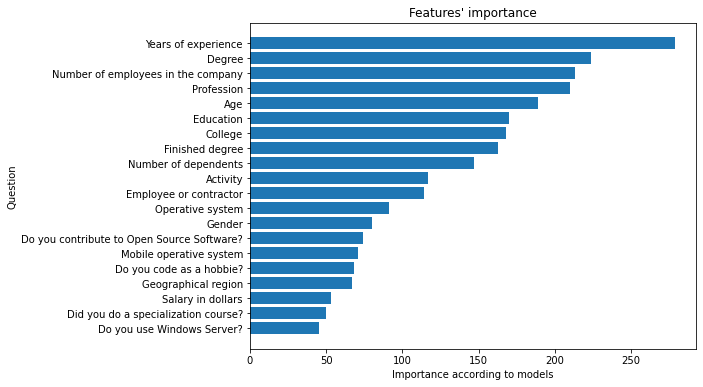

In [22]:
features = models['gender-aware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-aware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data = data.reset_index()
data['question'] = data['index'].apply(lambda x: x if (
    '=' not in x or
    x.startswith('Bases de datos') or
    x.startswith('Beneficios extra') or
    x.startswith('Frameworks, herramientas y librerías') or
    x.startswith('IDEs') or
    x.startswith('Lenguajes de programación') or
    x.startswith('Plataformas') or
    x.startswith('QA / Testing') or
    x.startswith('Realizaste cursos de especialización')
) else x.split('=')[0])
data = data.drop('index', axis=1).groupby('question').sum()
data = data.sort_values(by = "score", ascending=True).tail(20)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.barh([{
    'Años de experiencia': 'Years of experience',
    'Carrera': 'Degree',
    'Cantidad de empleados': 'Number of employees in the company',
    'Trabajo de': 'Profession',
    'Tengo': 'Age',
    'Nivel de estudios alcanzado': 'Education',
    'Universidad': 'College',
    'Estado': 'Finished degree',
    '¿Gente a cargo?': 'Number of dependents',
    'Actividad principal': 'Activity',
    'Tipo de contrato': 'Employee or contractor',
    '¿Qué SO usás en tu laptop/PC para trabajar?': 'Operative system',
    'Me identifico': 'Gender',
    '¿Contribuís a proyectos open source?': 'Do you contribute to Open Source Software?',
    '¿Y en tu celular?': 'Mobile operative system',
    '¿Programás como hobbie?': 'Do you code as a hobbie?',
    'region': 'Geographical region',
    'Beneficios extra=sueldo dolarizado': 'Salary in dollars',
    'Realizaste cursos de especialización=de forma particular': 'Did you do a specialization course?',
    'Plataformas=windows server': 'Do you use Windows Server?',
}.get(x, x) for x in data.index], data['score'])
ax.set_title("Features' importance")
ax.set_ylabel('Question')
ax.set_xlabel('Importance according to models')
ax.patch.set_alpha(0.0)
None;

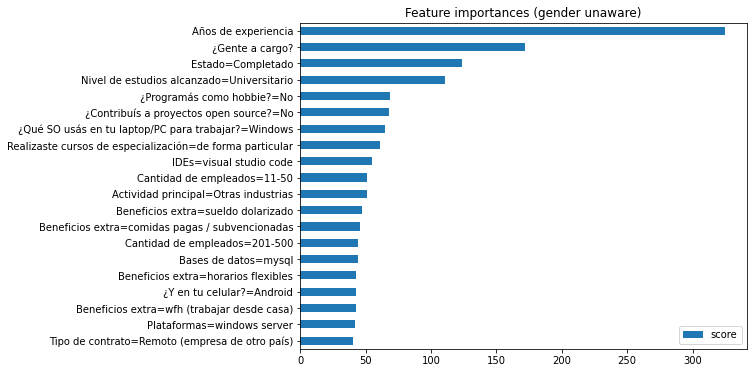

In [23]:
features = models['gender-unaware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-unaware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True).tail(20)
data.plot(kind='barh', figsize=(8, 6), title='Feature importances (gender unaware)');

## Balance number of women in the sample

In [24]:
men_per_woman = df['Me identifico'].value_counts()['Hombre'] / df['Me identifico'].value_counts()['Mujer']
kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_models = []
for train_index, test_index in kf.split(df):
    model = Model(random_state=99).fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'],
                       sample_weight=df.iloc[train_index]['Me identifico'].apply(lambda g: 1.0 if g == 'Hombre' else men_per_woman))
    df.loc[df.index[test_index], 'e_weighted(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    df.loc[df.index[test_index], 'e_gr_weighted(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    kf_models.append(model)
df['e_h_weighted(salary)'] = df.apply(lambda row: row['e_weighted(salary)'] if row['Me identifico'] == 'Hombre' else row['e_gr_weighted(salary)'], axis=1)
df['e_m_weighted(salary)'] = df.apply(lambda row: row['e_weighted(salary)'] if row['Me identifico'] == 'Mujer' else row['e_gr_weighted(salary)'], axis=1)
df['e_g_diff_weighted(salary)'] = (df['e_h_weighted(salary)'] - df['e_m_weighted(salary)']) / df['e_h_weighted(salary)']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [25]:
(
df['e_g_diff_weighted(salary)'].mean(),
df[(df['Me identifico'] == 'Hombre')]['e_g_diff_weighted(salary)'].mean(),
df[(df['Me identifico'] == 'Mujer')]['e_g_diff_weighted(salary)'].mean(),
)

(0.057711881666599026, 0.05480982673786241, 0.0751312894217717)

## Features that affect the income the most

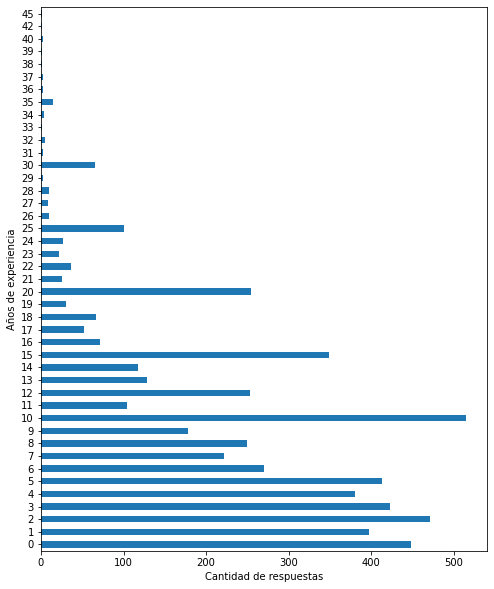

In [28]:
ax = df['Años de experiencia'].apply(math.floor).value_counts().sort_index().plot.barh(figsize=(8, 10));
ax.set_xlabel('Cantidad de respuestas');
ax.set_ylabel('Años de experiencia');


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


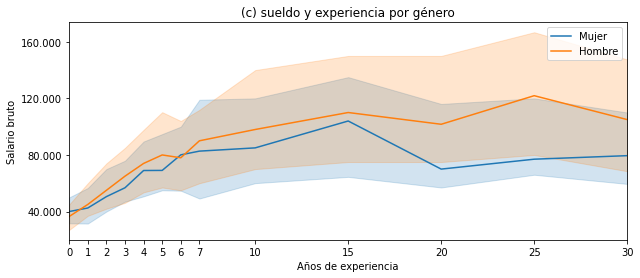

In [29]:
df['exp_round'] = df['Años de experiencia'].apply(lambda x: math.floor(x if x <= 7 else (5 * (x // 5))))
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_xlim(0, 30)
rang = [0, 1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30]
ax.set_xticks(rang)
w = df[(df['Me identifico'] == 'Mujer') & (df['Años de experiencia'] < 33)].groupby('exp_round')['Salario mensual BRUTO (en tu moneda local)']
m = df[(df['Me identifico'] == 'Hombre') & (df['Años de experiencia'] < 33)].groupby('exp_round')['Salario mensual BRUTO (en tu moneda local)']
ax.plot(w.median())
ax.plot(m.median())
ax.legend(['Mujer', 'Hombre', ])
ax.set_title('(c) sueldo y experiencia por género')
ax.set_yticks([160000, 120000, 80000, 40000])
ax.set_yticklabels(['160.000', '120.000', '80.000', '40.000'])
ax.fill_between(rang, w.quantile(0.25), w.quantile(0.75), color=cm + '33')
ax.fill_between(rang, m.quantile(0.25), m.quantile(0.75), color=ch + '33')
ax.set_ylabel('Salario bruto')
ax.set_xlabel('Años de experiencia')
None;

In [30]:
pd.concat((
    m.quantile(0.25).rename('Q1 Hombre'),
    m.quantile(0.5).rename('Q2 Hombre'),
    m.quantile(0.75).rename('Q3 Hombre'),
    w.quantile(0.25).rename('Q1 Mujer'),
    w.quantile(0.5).rename('Q2 Mujer'),
    w.quantile(0.75).rename('Q3 Mujer'),
), axis=1).astype(int)

,Q1 Hombre,Q2 Hombre,Q3 Hombre,Q1 Mujer,Q2 Mujer,Q3 Mujer
exp_round,,,,,,
0,27000,36500,45000,31655,40000,50000
1,36950,45000,60000,31506,42500,56622
2,42000,55000,74000,40000,50535,70000
3,46125,65000,85000,47000,56800,75914
4,53567,74000,97750,50750,69000,89500
5,57000,80000,110250,55022,69071,94750
6,55000,78000,104000,54740,80080,100000
7,60000,90000,111880,49200,82700,119000
10,70000,98000,140000,60063,85000,120000



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


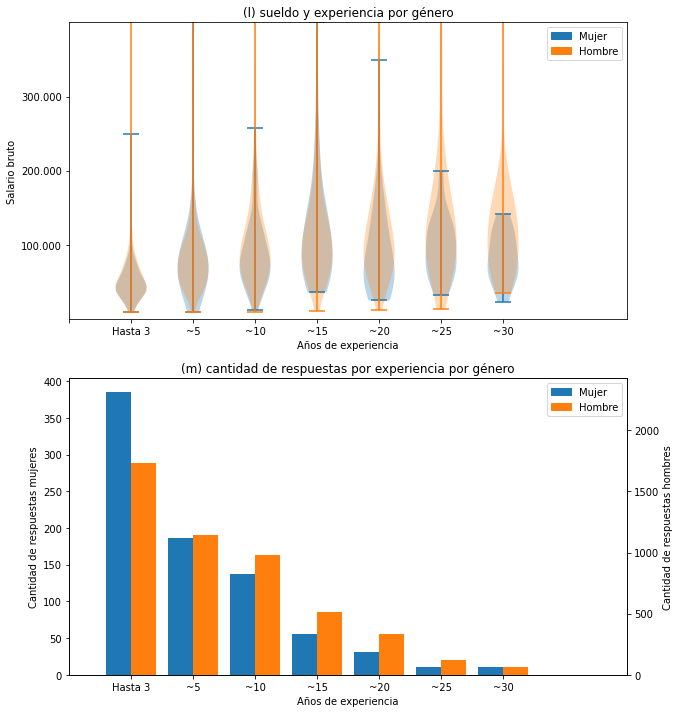

In [31]:
df['exp_round'] = df['Años de experiencia'].apply(lambda x: math.floor(5 * (x // 5)))
totalw = df[(df['Me identifico'] == 'Mujer') & (df['Años de experiencia'] < 33)].shape[0]
totalm = df[(df['Me identifico'] == 'Hombre') & (df['Años de experiencia'] < 33)].shape[0]
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 12))
ax0.set_ylim(0, 400_000)
ax0.set_xlim(0, 9)
ax0.set_xticks(range(8))
ax1.set_xlim(-1, 8)
ax1.set_xticks(range(8))

w = df[(df['Me identifico'] == 'Mujer') & (df['Años de experiencia'] < 33)]
m = df[(df['Me identifico'] == 'Hombre') & (df['Años de experiencia'] < 33)]

ax0.legend(['Mujer', 'Hombre', ])
ax0.set_title('(l) sueldo y experiencia por género')
ax0.set_yticks([300_000, 200_000, 100_000])
ax0.set_yticklabels(['300.000', '200.000', '100.000'])
ax0.set_ylabel('Salario bruto')
ax0.set_xlabel('Años de experiencia')
ax0.set_xticklabels(['', 'Hasta 3', '~5', '~10', '~15', '~20', '~25', '~30'])
ax0.violinplot([
    w[w['Años de experiencia'] <= 3]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(3 < w['Años de experiencia']) & (w['Años de experiencia'] <= 7)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(7 < w['Años de experiencia']) & (w['Años de experiencia'] <= 12)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(12 < w['Años de experiencia']) & (w['Años de experiencia'] <= 17)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(17 < w['Años de experiencia']) & (w['Años de experiencia'] <= 22)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(22 < w['Años de experiencia']) & (w['Años de experiencia'] <= 27)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(27 < w['Años de experiencia']) & (w['Años de experiencia'] <= 32)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
])
ax0.violinplot([
    m[m['Años de experiencia'] <= 3]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(3 < m['Años de experiencia']) & (m['Años de experiencia'] <= 7)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(7 < m['Años de experiencia']) & (m['Años de experiencia'] <= 12)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(12 < m['Años de experiencia']) & (m['Años de experiencia'] <= 17)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(17 < m['Años de experiencia']) & (m['Años de experiencia'] <= 22)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(22 < m['Años de experiencia']) & (m['Años de experiencia'] <= 27)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(27 < m['Años de experiencia']) & (m['Años de experiencia'] <= 32)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
])
ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

w = df[(df['Me identifico'] == 'Mujer') & (df['Años de experiencia'] < 33)].groupby('exp_round')['Salario mensual BRUTO (en tu moneda local)']
m = df[(df['Me identifico'] == 'Hombre') & (df['Años de experiencia'] < 33)].groupby('exp_round')['Salario mensual BRUTO (en tu moneda local)']
ax2 = ax1.twinx()
ax1.set_xticks(range(len(w.count().index)))
ax1.set_xticklabels(w.count().index)
ax1.bar([x - 0.2 for x in range(len(w.count().index))], w.count().values, 0.4, color=cm)
ax2.bar([x + 0.2 for x in range(len(m.count().index))], m.count().values, 0.4, color=ch)
ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])
ax1.set_title('(m) cantidad de respuestas por experiencia por género')
ax1.set_ylabel('Cantidad de respuestas mujeres')
ax2.set_ylabel('Cantidad de respuestas hombres')
ax1.set_xlabel('Años de experiencia')
ax1.set_xticklabels(['Hasta 3', '~5', '~10', '~15', '~20', '~25', '~30'])

if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
    ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
else:
    ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

plt.show()
None;

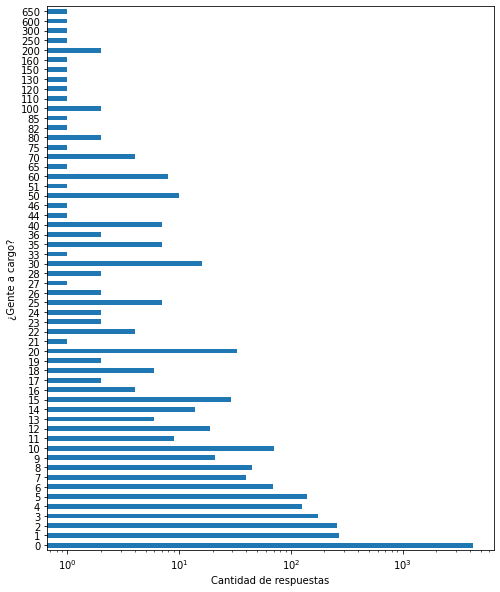

In [32]:
ax = df['¿Gente a cargo?'].fillna(0).astype(int).value_counts().sort_index().plot.barh(figsize=(8, 10));
ax.set_xlabel('Cantidad de respuestas');
ax.set_ylabel('¿Gente a cargo?');
ax.set_xscale('log');

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


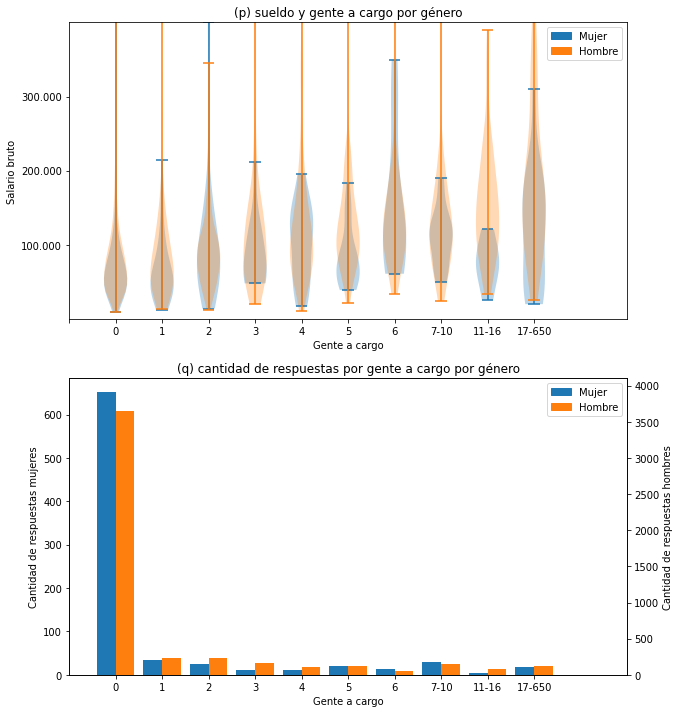

In [33]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 12))
gente_a_cargo_gt_0 = df['¿Gente a cargo?'][df['¿Gente a cargo?'].fillna('0').astype(int) > 0].fillna('0').astype(int)
qs = sorted(set([0]).union(set((int(gente_a_cargo_gt_0.quantile(i / 10)) for i in range(10))))) + [gente_a_cargo_gt_0.max()]
ax0.set_ylim(0, 400_000)
ax0.set_xlim(0, len(qs)+2)

ax0.set_title('(p) sueldo y gente a cargo por género')
ax0.set_yticks([300_000, 200_000, 100_000])
ax0.set_yticklabels(['300.000', '200.000', '100.000'])
ax0.set_ylabel('Salario bruto')
ax0.set_xlabel('Gente a cargo')
ax0.set_xticklabels([''] + ['0' if i == 0 else (str(q) if q == qs[i-1]+1 else f'{qs[i-1]+1}-{q}') for i, q in enumerate(qs)])
ax0.set_xticks(range(len(qs)+1))

w = df[df['Me identifico'] == 'Mujer']
wgac = w['¿Gente a cargo?'].astype(int)
ax0.violinplot([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].to_list() for i, q in enumerate(qs)
])

m = df[df['Me identifico'] == 'Hombre']
mgac = m['¿Gente a cargo?'].astype(int)
ax0.violinplot([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].to_list() for i, q in enumerate(qs)
])
ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


gente_a_cargo_gt_0 = df['¿Gente a cargo?'][df['¿Gente a cargo?'].fillna('0').astype(int) > 0].fillna('0').astype(int)
qs = sorted(set([0]).union(set((int(gente_a_cargo_gt_0.quantile(i / 10)) for i in range(10))))) + [gente_a_cargo_gt_0.max()]
totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

ax2 = ax1.twinx()
ax1.set_title('(q) cantidad de respuestas por gente a cargo por género')
ax1.set_ylabel('Cantidad de respuestas mujeres')
ax2.set_ylabel('Cantidad de respuestas hombres')
ax1.set_xlabel('Gente a cargo')
ax1.set_xticklabels(['0' if i == 0 else (str(q) if q == qs[i-1]+1 else f'{qs[i-1]+1}-{q}') for i, q in enumerate(qs)])
ax1.set_xticks(range(len(qs)))
ax1.set_xlim(-1, len(qs)+1)

w = df[df['Me identifico'] == 'Mujer']
wgac = w['¿Gente a cargo?'].astype(int)
ax1.bar([x - 0.2 for x in range(len(qs))], [data for data in [
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))].shape[0] for (i, q) in enumerate(qs)
]], 0.4, color=cm)

m = df[df['Me identifico'] == 'Hombre']
mgac = m['¿Gente a cargo?'].astype(int)
ax2.bar([x + 0.2 for x in range(len(qs))], [data for data in [
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))].shape[0] for (i, q) in enumerate(qs)
]], 0.4, color=ch)
ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
    ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
else:
    ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

plt.show()
None;

In [34]:
pd.concat((
pd.Series([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for i, q in enumerate(qs)
]).rename('Q1 Mujer'), pd.Series([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for i, q in enumerate(qs)
]).rename('Q2 Mujer'), pd.Series([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for i, q in enumerate(qs)
]).rename('Q3 Mujer'), pd.Series([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, q in enumerate(qs)
]).rename('Mujeres'),
pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for i, q in enumerate(qs)
]).rename('Q1 Hombre'), pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for i, q in enumerate(qs)
]).rename('Q2 Hombre'), pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for i, q in enumerate(qs)
]).rename('Q3 Hombre'), pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, q in enumerate(qs)
]).rename('Hombres'), pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] / w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, q in enumerate(qs)
]).rename('Hombres por mujer'),
), axis=1).astype(int).T.rename(columns={i: '0' if i == 0 else (str(q) if q == qs[i-1]+1 else f'{qs[i-1]+1}-{q}') for i, q in enumerate(qs)}).T

,Q1 Mujer,Q2 Mujer,Q3 Mujer,Mujeres,Q1 Hombre,Q2 Hombre,Q3 Hombre,Hombres,Hombres por mujer
0,40000,60000,82000,651,46500,70000,100000,3653,5
1,36500,55063,78000,34,47950,70000,110000,235,6
2,56500,80000,120000,24,60000,85000,115000,235,9
3,56250,65000,112340,11,62000,100000,140000,165,15
4,54625,114864,141250,12,72000,107000,150000,114,9
5,54000,70000,100000,21,86500,113000,158000,119,5
6,97288,115500,187500,14,97000,120000,160000,55,3
7-10,78287,110000,129500,30,90000,116706,160000,147,4
11-16,67400,70000,90000,5,100000,145000,192500,76,15
17-650,50250,131000,167500,18,113036,160000,241000,123,6


FixedFormatter should only be used together with FixedLocator


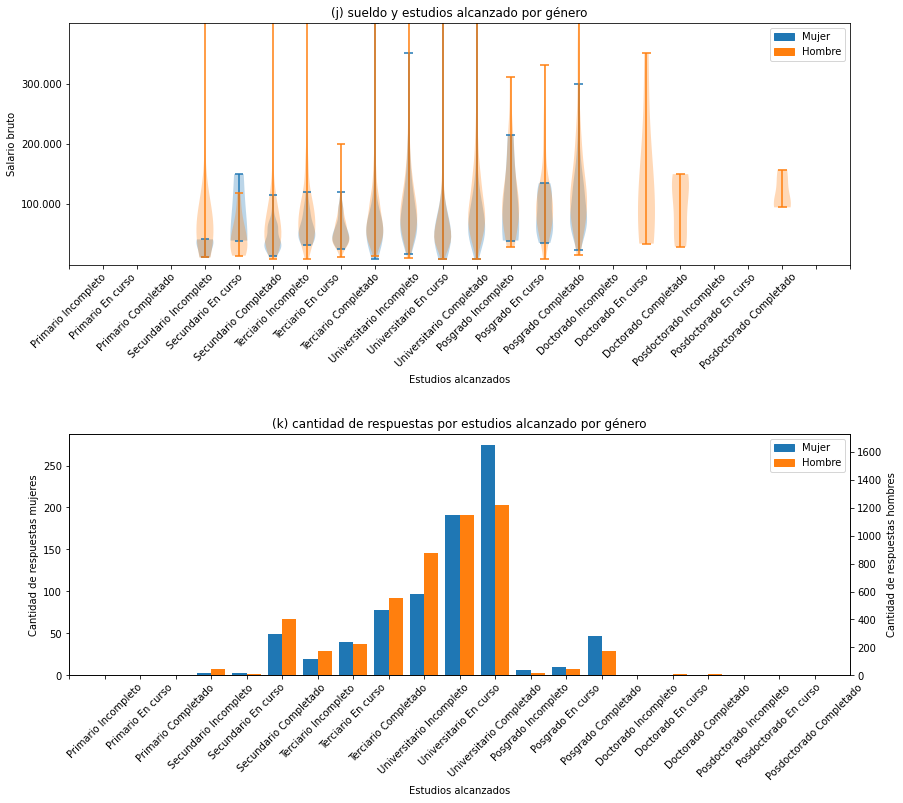

In [35]:
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(14, 12))
f.subplots_adjust(hspace=0.7)
degrees = 'Primario', 'Secundario', 'Terciario', 'Universitario', 'Posgrado', 'Doctorado', 'Posdoctorado'
degrees_status = 'Incompleto', 'En curso', 'Completado'
ds = [(d, ds) for d in degrees for ds in degrees_status]
ax0.set_ylim(0, 400_000)
ax0.set_xlim(0, len(ds)+1)
ax1.set_xticks(range(len(ds)))
ax1.set_xlim(-1, len(ds))

ax0.set_title('(j) sueldo y estudios alcanzado por género')
ax0.set_yticks([300_000, 200_000, 100_000])
ax0.set_yticklabels(['300.000', '200.000', '100.000'])
ax0.set_ylabel('Salario bruto')
ax0.set_xlabel('Estudios alcanzados')
ax0.set_xticklabels([f'{d} {s}' for d, s in ds], rotation=45)
ax0.set_xticks(range(-1, len(ds)+2))

w = df[df['Me identifico'] == 'Mujer']
wd = w['Nivel de estudios alcanzado']
ws = w['Estado']
ax0.violinplot([data for data in [
    w[(wd == d) & (ws == s)]['Salario mensual BRUTO (en tu moneda local)'].to_list() for (d, s) in ds
] if len(data) > 1], positions=[i for i, data in enumerate([
    w[(wd == d) & (ws == s)]['Salario mensual BRUTO (en tu moneda local)'].to_list() for (d, s) in ds
]) if len(data) > 1])

m = df[df['Me identifico'] == 'Hombre']
md = m['Nivel de estudios alcanzado']
ms = m['Estado']
ax0.violinplot([data for data in [
    m[(md == d) & (ms == s)]['Salario mensual BRUTO (en tu moneda local)'].to_list() for (d, s) in ds
] if len(data) > 1], positions=[i for i, data in enumerate([
    m[(md == d) & (ms == s)]['Salario mensual BRUTO (en tu moneda local)'].to_list() for (d, s) in ds
]) if len(data) > 1])
ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

ax2 = ax1.twinx()
ax1.set_title('(k) cantidad de respuestas por estudios alcanzado por género')
ax1.set_ylabel('Cantidad de respuestas mujeres')
ax2.set_ylabel('Cantidad de respuestas hombres')
ax1.set_xlabel('Estudios alcanzados')
ax1.set_xticklabels([f'{d} {s}' for d, s in ds], rotation=45)
ax1.set_xticks(range(-1, len(ds)))

w = df[df['Me identifico'] == 'Mujer']
wd = w['Nivel de estudios alcanzado']
ws = w['Estado']
ax1.bar([x - 0.2 for x in range(len(ds))], [data for data in [
    w[(wd == d) & (ws == s)].shape[0] for (d, s) in ds
]], 0.4, color=cm)

m = df[df['Me identifico'] == 'Hombre']
md = m['Nivel de estudios alcanzado']
ms = m['Estado']
ax2.bar([x + 0.2 for x in range(len(ds))], [data for data in [
    m[(md == d) & (ms == s)].shape[0] for (d, s) in ds
]], 0.4, color=ch)
ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
    ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
else:
    ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

plt.show()
None;

In [36]:
degree_distribution_w = [w[(wd == d) & (ws == s)]['Salario mensual BRUTO (en tu moneda local)'] for (d, s) in ds]
degree_distribution_m = [m[(md == d) & (ms == s)]['Salario mensual BRUTO (en tu moneda local)'] for (d, s) in ds]

pd.concat((
pd.Series([
   degree_distribution_w[i].quantile(0.25) for i, q in enumerate(ds)
]).rename('Q1 Mujer'), pd.Series([
    degree_distribution_w[i].quantile(0.5) for i, q in enumerate(ds)
]).rename('Q2 Mujer'), pd.Series([
    degree_distribution_w[i].quantile(0.75) for i, q in enumerate(ds)
]).rename('Q3 Mujer'), pd.Series([
    degree_distribution_w[i].shape[0] for i, q in enumerate(ds)
]).rename('Mujeres'),
pd.Series([
    degree_distribution_m[i].quantile(0.25) for i, q in enumerate(ds)
]).rename('Q1 Hombre'), pd.Series([
    degree_distribution_m[i].quantile(0.5) for i, q in enumerate(ds)
]).rename('Q2 Hombre'), pd.Series([
    degree_distribution_m[i].quantile(0.75) for i, q in enumerate(ds)
]).rename('Q3 Hombre'), pd.Series([
    degree_distribution_m[i].shape[0] for i, q in enumerate(ds)
]).rename('Hombres'),
), axis=1).fillna(-1).astype(int).T.rename(columns={i: f'{d} {s}' for i, (d, s) in enumerate(ds)}).T

,Q1 Mujer,Q2 Mujer,Q3 Mujer,Mujeres,Q1 Hombre,Q2 Hombre,Q3 Hombre,Hombres
Primario Incompleto,-1,-1,-1,0,-1,-1,-1,0
Primario En curso,-1,-1,-1,0,-1,-1,-1,0
Primario Completado,-1,-1,-1,0,23470,23470,23470,1
Secundario Incompleto,24000,36000,39000,3,39250,58500,78703,46
Secundario En curso,40000,40000,95000,3,20000,43000,65000,13
Secundario Completado,27991,36000,60000,49,40000,62000,91750,406
Terciario Incompleto,45050,55000,72700,19,50000,75591,105000,172
Terciario En curso,39750,49795,64250,40,39000,50000,70100,223
Terciario Completado,40000,60000,75537,78,50000,71773,105000,555
Universitario Incompleto,56000,80000,120000,97,65000,93000,132000,875


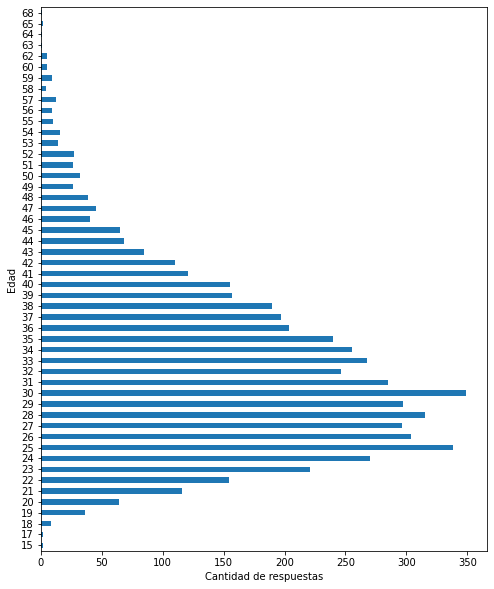

In [37]:
ax = df['Tengo'].apply(math.floor).value_counts().sort_index().plot.barh(figsize=(8, 10));
ax.set_xlabel('Cantidad de respuestas');
ax.set_ylabel('Edad');

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


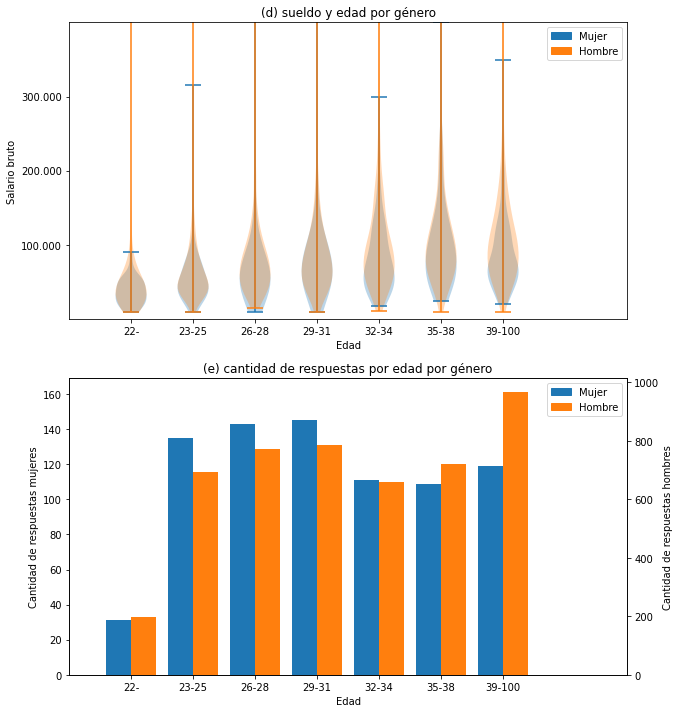

,Q1 Mujer,Q2 Mujer,Q3 Mujer,Mujeres,Q1 Hombre,Q2 Hombre,Q3 Hombre,Hombres
22-,22500,35000,50000,31,26000,38000,50000,197
23-25,35000,47000,70000,135,39700,54062,75000,694
26-28,41650,55126,73500,143,48000,70000,100000,772
29-31,47300,70000,92778,145,52365,76000,109000,786
32-34,47050,70000,114000,111,60000,90000,135000,658
35-38,60000,85000,120000,109,70000,98000,140000,722
39-100,57500,71800,110000,119,69250,100000,141000,966


In [38]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 12))
ages = [22, 25, 28, 31, 34, 38, 100]
ax0.set_ylim(0, 400_000)
ax0.set_xlim(0, len(ages)+2)

ax0.set_title('(d) sueldo y edad por género')
ax0.set_yticks([300_000, 200_000, 100_000])
ax0.set_yticklabels(['300.000', '200.000', '100.000'])
ax0.set_ylabel('Salario bruto')
ax0.set_xlabel('Edad')
ax0.set_xticklabels([f'{age}-' if i == 0 else f'{ages[i-1]+1}-{age}' for i, age in enumerate(ages)])
ax0.set_xticks(range(1, len(ages)+1))

w = df[df['Me identifico'] == 'Mujer']
wage = w['Tengo'].astype(int)
ax0.violinplot([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].to_list() for i, age in enumerate(ages)
])

m = df[df['Me identifico'] == 'Hombre']
mage = m['Tengo'].astype(int)
ax0.violinplot([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].to_list() for i, age in enumerate(ages)
])
ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

ax2 = ax1.twinx()
ax1.set_title('(e) cantidad de respuestas por edad por género')
ax1.set_ylabel('Cantidad de respuestas mujeres')
ax2.set_ylabel('Cantidad de respuestas hombres')
ax1.set_xlabel('Edad')
ax1.set_xticklabels([f'{age}-' if i == 0 else f'{ages[i-1]+1}-{age}' for i, age in enumerate(ages)])
ax1.set_xticks(range(len(ages)))
ax1.set_xlim(-1, len(ages)+1)

w = df[df['Me identifico'] == 'Mujer']
ax1.bar([x - 0.2 for x in range(len(ages))], [data for data in [
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))].shape[0] for (i, age) in enumerate(ages)
]], 0.4, color=cm)

m = df[df['Me identifico'] == 'Hombre']
ax2.bar([x + 0.2 for x in range(len(ages))], [data for data in [
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))].shape[0] for (i, age) in enumerate(ages)
]], 0.4, color=ch)
ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
    ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
else:
    ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

plt.show()

pd.concat((
pd.Series([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for i, age in enumerate(ages)
]).rename('Q1 Mujer'), pd.Series([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for i, age in enumerate(ages)
]).rename('Q2 Mujer'), pd.Series([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for i, age in enumerate(ages)
]).rename('Q3 Mujer'), pd.Series([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, age in enumerate(ages)
]).rename('Mujeres'),
pd.Series([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for i, age in enumerate(ages)
]).rename('Q1 Hombre'), pd.Series([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for i, age in enumerate(ages)
]).rename('Q2 Hombre'), pd.Series([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for i, age in enumerate(ages)
]).rename('Q3 Hombre'), pd.Series([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, age in enumerate(ages)
]).rename('Hombres'),
), axis=1).astype(int).T.rename(columns={i: f'{age}-' if i == 0 else f'{ages[i-1]+1}-{age}' for i, age in enumerate(ages)}).T

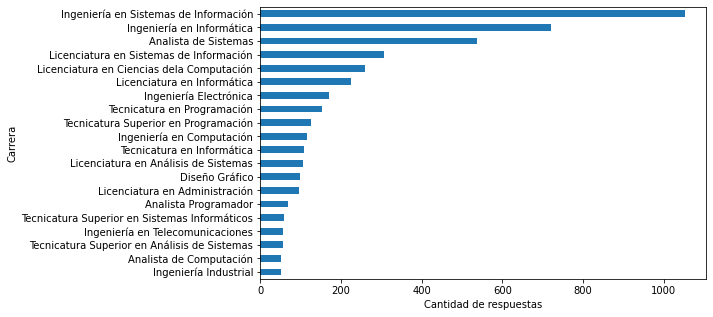

In [39]:
ax = df['Carrera'].value_counts().sort_values().tail(20).plot.barh(figsize=(8, 5));
ax.set_xlabel('Cantidad de respuestas');
ax.set_ylabel('Carrera');

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


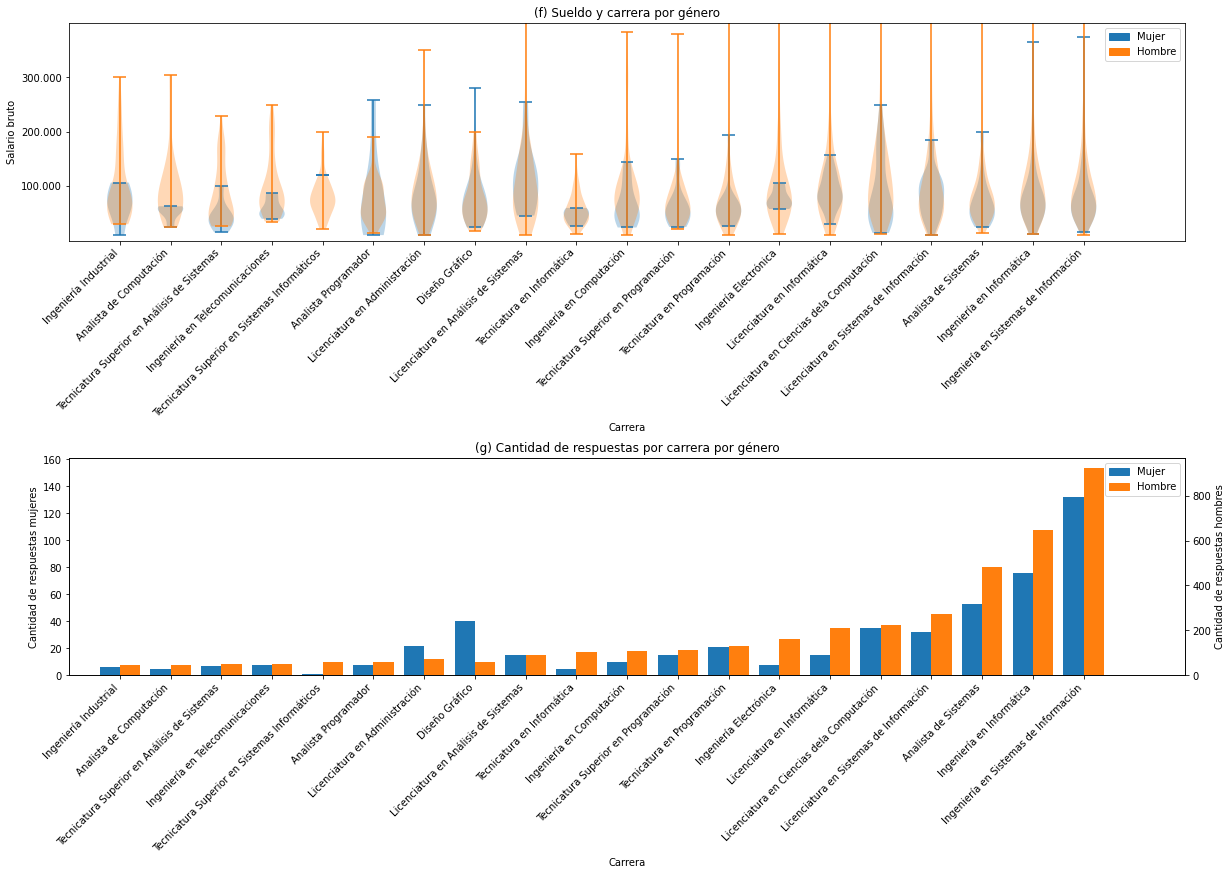

|                                               |   Q1 Mujer |   Q2 Mujer |   Q3 Mujer |   Mujeres |   Q1 Hombre |   Q2 Hombre |   Q3 Hombre |   Hombres |
|:----------------------------------------------|-----------:|-----------:|-----------:|----------:|------------:|------------:|------------:|----------:|
| Ingeniería Industrial                         |      57500 |      68500 |      91500 |         6 |       55000 |       78000 |      142500 |        47 |
| Analista de Computación                       |      52000 |      59500 |      59600 |         5 |       56500 |       79500 |      111375 |        48 |
| Tecnicatura Superior en Análisis de Sistemas  |      36000 |      40000 |      44395 |         7 |       41026 |       70108 |      112500 |        50 |
| Ingeniería en Telecomunicaciones              |      46975 |      52000 |      71372 |         8 |       64000 |       80000 |      120000 |        49 |
| Tecnicatura Superior en Sistemas Informáticos |     120000 |     120

In [40]:
def plot_gpg(categories, letter1, title1, label, column, letter2, title2, hspace=None, rotation=None, horizontalalignment=None, figsize=(10, 12)):
    f, (ax0, ax1) = plt.subplots(2, 1, figsize=figsize)
    f.subplots_adjust(hspace=hspace)

    ax0.set_ylim(0, 400_000)
    ax0.set_xlim(0, len(categories)+2)

    ax0.set_title(f'({letter1}) {title1}')
    ax0.set_yticks([300_000, 200_000, 100_000])
    ax0.set_yticklabels(['300.000', '200.000', '100.000'])
    ax0.set_ylabel('Salario bruto')
    ax0.set_xlabel(label)
    ax0.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
    ax0.set_xticks(range(1, 1+len(categories)))

    w = df[df['Me identifico'] == 'Mujer']
    ax0.violinplot([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ])

    m = df[df['Me identifico'] == 'Hombre']
    ax0.violinplot([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ])
    ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


    totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
    totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

    ax2 = ax1.twinx()
    ax1.set_title(f'({letter2}) {title2}')
    ax1.set_ylabel('Cantidad de respuestas mujeres')
    ax2.set_ylabel('Cantidad de respuestas hombres')
    ax1.set_xlabel(label)
    ax1.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
    ax1.set_xticks(range(0,len(categories)))
    ax1.set_xlim(-1, len(categories)+1)
    ax1.bar([x - 0.2 for x in range(len(categories))], [data for data in [
        w[w[column] == cat].shape[0] for cat in categories
    ]], 0.4, color=cm)
    ax2.bar([x + 0.2 for x in range(len(categories))], [data for data in [
        m[m[column] == cat].shape[0] for cat in categories
    ]], 0.4, color=ch)
    ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

    if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
        ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
    else:
        ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

    plt.show()

    print(
    pd.concat((
    pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for cat in categories
    ]).rename('Q1 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for cat in categories
    ]).rename('Q2 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75)  for cat in categories
    ]).rename('Q3 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for cat in categories
    ]).rename('Mujeres'),
    pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25)  for cat in categories
    ]).rename('Q1 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5)  for cat in categories
    ]).rename('Q2 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for cat in categories
    ]).rename('Q3 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for cat in categories
    ]).rename('Hombres'),
    ), axis=1).astype(int).T.rename(columns={i: cat for i, cat in enumerate(categories)}).T
    .to_markdown())

plot_gpg(
    categories=df['Carrera'].value_counts().sort_values().tail(20).index.tolist(),
    letter1='f',
    title1='Sueldo y carrera por género',
    label='Carrera',
    column='Carrera',
    letter2='g',
    title2='Cantidad de respuestas por carrera por género',
    hspace=1,
    rotation=45,
    horizontalalignment='right',
    figsize=(20, 12)
)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


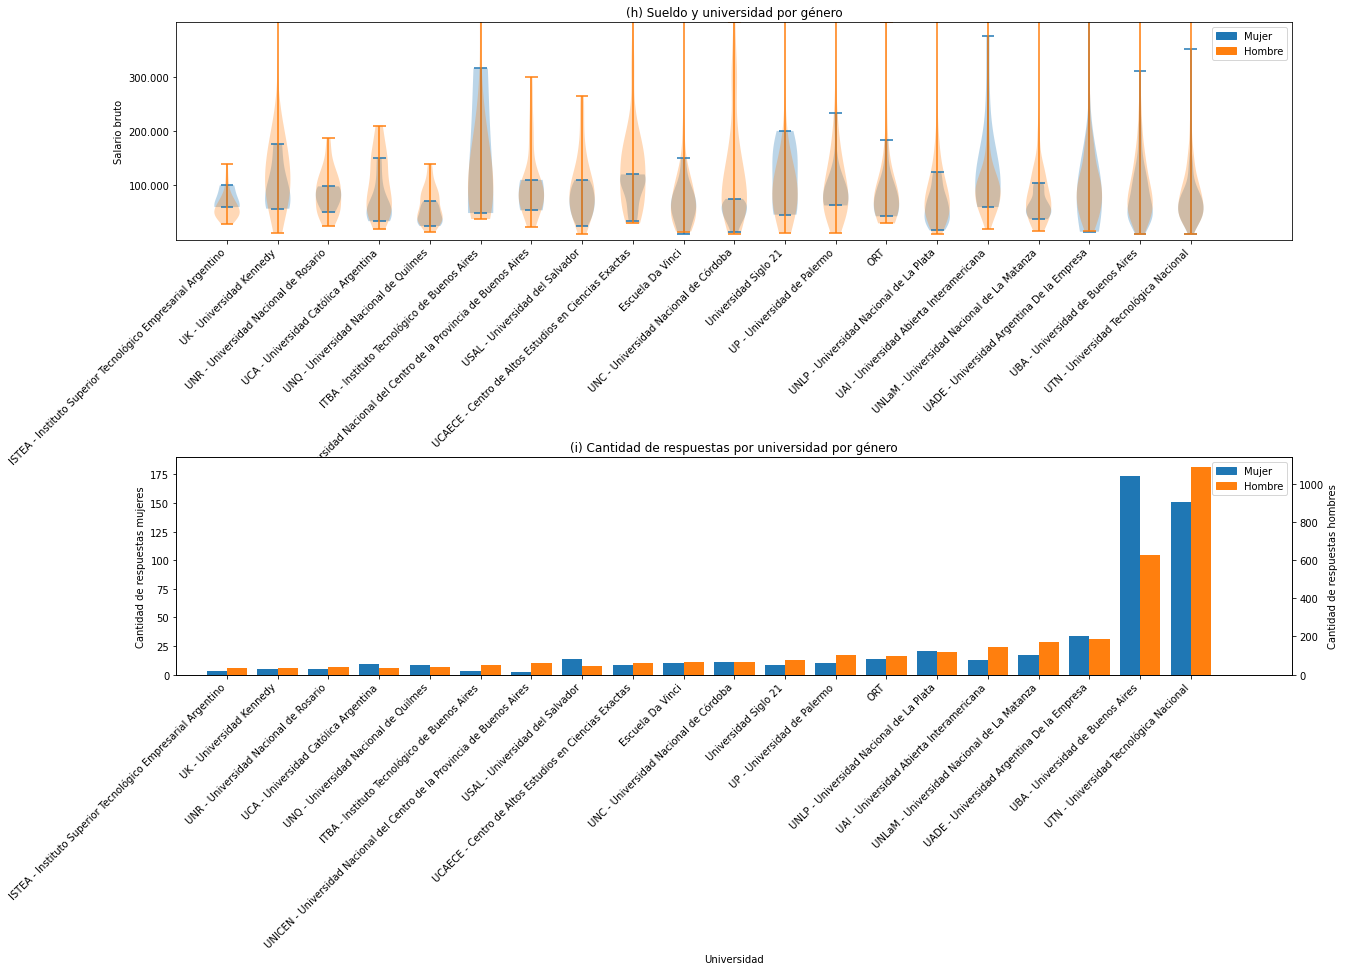

|                                                                          |   Q1 Mujer |   Q2 Mujer |   Q3 Mujer |   Mujeres |   Q1 Hombre |   Q2 Hombre |   Q3 Hombre |   Hombres |
|:-------------------------------------------------------------------------|-----------:|-----------:|-----------:|----------:|------------:|------------:|------------:|----------:|
| ISTEA - Instituto Superior Tecnológico Empresarial Argentino             |      60750 |      61500 |      80750 |         3 |       46000 |       54405 |       70000 |        35 |
| UK - Universidad Kennedy                                                 |      62000 |      80000 |     108000 |         5 |       80000 |      112500 |      160000 |        34 |
| UNR - Universidad Nacional de Rosario                                    |      72000 |      75093 |      95000 |         5 |       56000 |       85000 |      110000 |        37 |
| UCA - Universidad Católica Argentina                                     |      42000 | 

In [41]:
plot_gpg(
    categories=df['Universidad'].value_counts().sort_values().tail(20).index.tolist(),
    letter1='h',
    title1='Sueldo y universidad por género',
    label='Universidad',
    column='Universidad',
    letter2='i',
    title2='Cantidad de respuestas por universidad por género',
    hspace=1,
    rotation=45,
    horizontalalignment='right',
    figsize=(20, 12)
)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


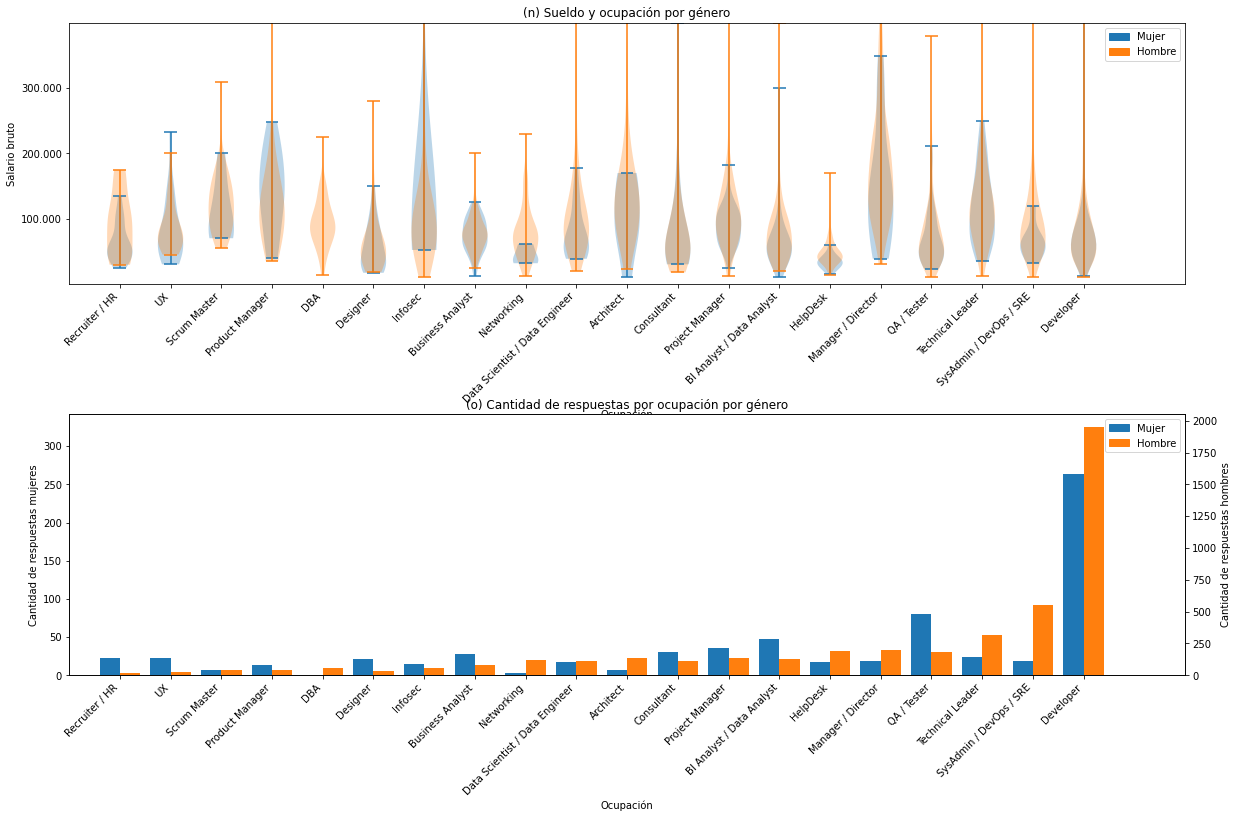

|                                |   Q1 Mujer |   Q2 Mujer |   Q3 Mujer |   Mujeres |   Q1 Hombre |   Q2 Hombre |   Q3 Hombre |   Hombres |
|:-------------------------------|-----------:|-----------:|-----------:|----------:|------------:|------------:|------------:|----------:|
| Recruiter / HR                 |      41800 |      56000 |      80000 |        23 |       47500 |      100000 |      110445 |        15 |
| UX                             |      54000 |      67000 |     105694 |        22 |       62250 |       74070 |       96250 |        24 |
| Scrum Master                   |      73500 |      89000 |     135000 |         7 |       91500 |      116353 |      150000 |        40 |
| Product Manager                |      97500 |     142500 |     193500 |        14 |       84650 |      102000 |      139000 |        39 |
| DBA                            |         -1 |         -1 |         -1 |         0 |       73000 |       91700 |      115843 |        55 |
| Designer          

In [42]:
def plot_gpg(categories, letter1, title1, label, column, letter2, title2, hspace=None, rotation=None, horizontalalignment=None, figsize=(10, 12)):
    f, (ax0, ax1) = plt.subplots(2, 1, figsize=figsize)
    f.subplots_adjust(hspace=hspace)

    ax0.set_ylim(0, 400_000)
    ax0.set_xlim(0, len(categories)+2)

    ax0.set_title(f'({letter1}) {title1}')
    ax0.set_yticks([300_000, 200_000, 100_000])
    ax0.set_yticklabels(['300.000', '200.000', '100.000'])
    ax0.set_ylabel('Salario bruto')
    ax0.set_xlabel(label)
    ax0.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
    ax0.set_xticks(range(1, 1+len(categories)))


    w = df[df['Me identifico'] == 'Mujer']

    ax0.violinplot([data for data in [
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ] if len(data) > 1], positions=[1+i for i, data in enumerate([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ]) if len(data) > 1])


    m = df[df['Me identifico'] == 'Hombre']
    ax0.violinplot([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ])
    ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


    totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
    totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

    ax2 = ax1.twinx()
    ax1.set_title(f'({letter2}) {title2}')
    ax1.set_ylabel('Cantidad de respuestas mujeres')
    ax2.set_ylabel('Cantidad de respuestas hombres')
    ax1.set_xlabel(label)
    ax1.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
    ax1.set_xticks(range(0,len(categories)))
    ax1.set_xlim(-1, len(categories)+1)
    ax1.bar([x - 0.2 for x in range(len(categories))], [data for data in [
        w[w[column] == cat].shape[0] for cat in categories
    ]], 0.4, color=cm)
    ax2.bar([x + 0.2 for x in range(len(categories))], [data for data in [
        m[m[column] == cat].shape[0] for cat in categories
    ]], 0.4, color=ch)
    ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

    if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
        ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
    else:
        ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

    plt.show()

    print(
    pd.concat((
    pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for cat in categories
    ]).rename('Q1 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for cat in categories
    ]).rename('Q2 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75)  for cat in categories
    ]).rename('Q3 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for cat in categories
    ]).rename('Mujeres'),
    pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25)  for cat in categories
    ]).rename('Q1 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5)  for cat in categories
    ]).rename('Q2 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for cat in categories
    ]).rename('Q3 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for cat in categories
    ]).rename('Hombres'),
    ), axis=1).fillna(-1).astype(int).T.rename(columns={i: cat for i, cat in enumerate(categories)}).T
    .to_markdown())

plot_gpg(
    categories=df['Trabajo de'].value_counts().sort_values().tail(20).index.tolist(),
    letter1='n',
    title1='Sueldo y ocupación por género',
    label='Ocupación',
    column='Trabajo de',
    letter2='o',
    title2='Cantidad de respuestas por ocupación por género',
    hspace=0.5,
    rotation=45,
    horizontalalignment='right',
    figsize=(20, 12)
)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


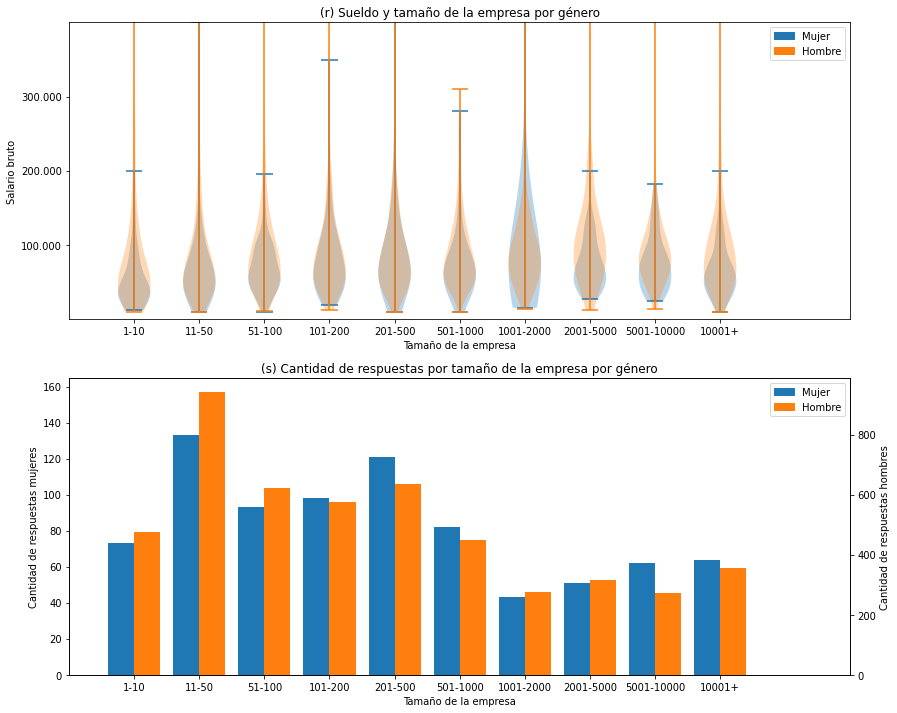

|            |   Q1 Mujer |   Q2 Mujer |   Q3 Mujer |   Mujeres |   Q1 Hombre |   Q2 Hombre |   Q3 Hombre |   Hombres |
|:-----------|-----------:|-----------:|-----------:|----------:|------------:|------------:|------------:|----------:|
| 1-10       |      28000 |      42000 |      70000 |        73 |       37250 |       55000 |      106500 |       475 |
| 11-50      |      36000 |      56000 |      80000 |       133 |       44000 |       69500 |      105000 |       941 |
| 51-100     |      46898 |      64000 |      93000 |        93 |       52000 |       78430 |      114000 |       623 |
| 101-200    |      45525 |      69186 |     101828 |        98 |       52000 |       78000 |      111300 |       577 |
| 201-500    |      50000 |      68000 |     100000 |       121 |       54000 |       80000 |      120000 |       636 |
| 501-1000   |      46000 |      66600 |      86262 |        82 |       55000 |       79490 |      113882 |       448 |
| 1001-2000  |      48300 |      70000 |

In [43]:
plot_gpg(
    categories=sorted(df['Cantidad de empleados'].unique().tolist(), key=lambda v: int(v.strip('+').split('-')[0])),
    letter1='r',
    title1='Sueldo y tamaño de la empresa por género',
    label='Tamaño de la empresa',
    column='Cantidad de empleados',
    letter2='s',
    title2='Cantidad de respuestas por tamaño de la empresa por género',
    horizontalalignment='center',
    figsize=(14, 12)
)